In [1]:
from statsmodels.tsa.stattools import adfuller

In [2]:
from numpy import log

In [3]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (9,7), 'figure.dpi': 120})

In [48]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df.head()

,value
0,88
1,84
2,85
3,85
4,84


In [5]:
result = adfuller(df.value.dropna())

In [6]:
print("ADF Statistics: %f" %result[0])

ADF Statistics: -2.464240


In [7]:
print("p-values: %f" %result[1])

p-values: 0.124419


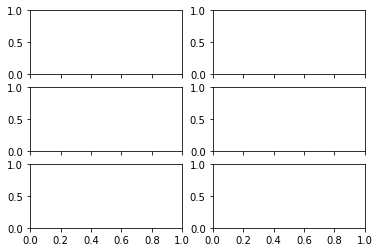

In [8]:
fig, axes = plt.subplots(3,2, sharex = True)

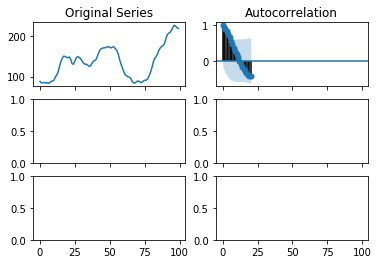

In [9]:
axes[0,0].plot(df.value); axes[0,0].set_title('Original Series')
plot_acf(df.value, ax = axes[0,1])

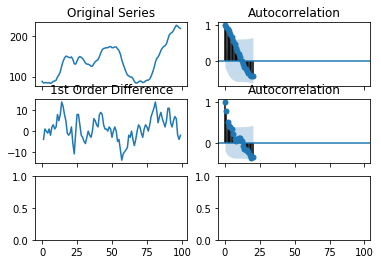

In [10]:
axes[1,0].plot(df.value.diff()); axes[1,0].set_title("1st Order Difference")
plot_acf(df.value.diff().dropna(), ax = axes[1,1])

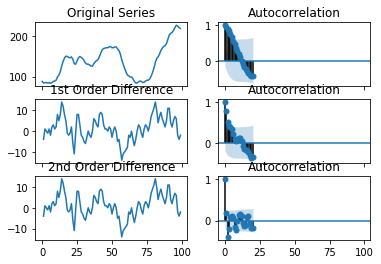

In [11]:
axes[2,0].plot(df.value.diff()); axes[2,0].set_title("2nd Order Difference")
plot_acf(df.value.diff().diff().dropna(), ax = axes[2,1])

In [12]:
plt.show()

In [13]:
from pmdarima.arima.utils import ndiffs

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

In [15]:
y = df.value

In [16]:
ndiffs(y, test = "adf")

2

In [17]:
ndiffs(y, test = "kpss")

0

In [18]:
ndiffs(y, test = "pp")

2

In [19]:
#PACF Plots
plt.rcParams.update({'figure.figsize': (9,3), 'figure.dpi' : 120})

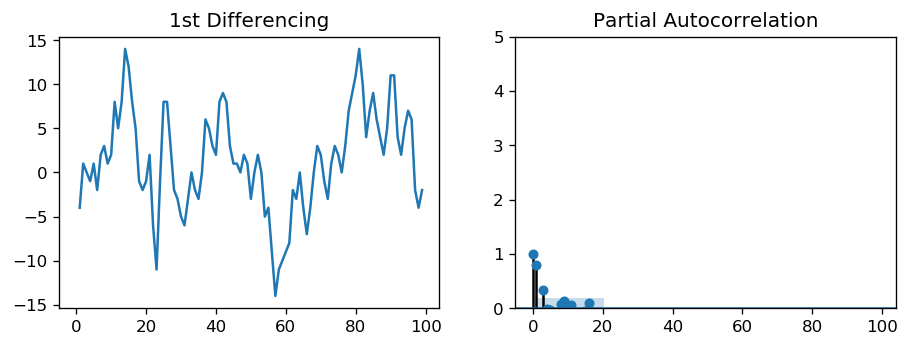

In [20]:
fig, axes = plt.subplots(1,2, sharex = True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim = (0,5))
plot_pacf(df.value.diff().dropna(), ax = axes[1])
plt.show()

In [21]:
from statsmodels.tsa.arima_model import ARIMA

In [22]:
model = ARIMA(df.value, order = (1,1,2))

In [23]:
model_fit = model.fit(disp = 0)

In [24]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Tue, 14 Jan 2020   AIC                            517.579
Time:                        11:19:43   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.387      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.015       0.131       1.139
ma.L1.D.value     0.5287      0.355     

In [25]:
model = ARIMA(df.value, order = (1,1,1))

In [26]:
model_fit = model.fit(disp = 0)

In [27]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Tue, 14 Jan 2020   AIC                            515.579
Time:                        11:19:44   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.386      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

In [28]:
residuals = pd.DataFrame(model_fit.resid)

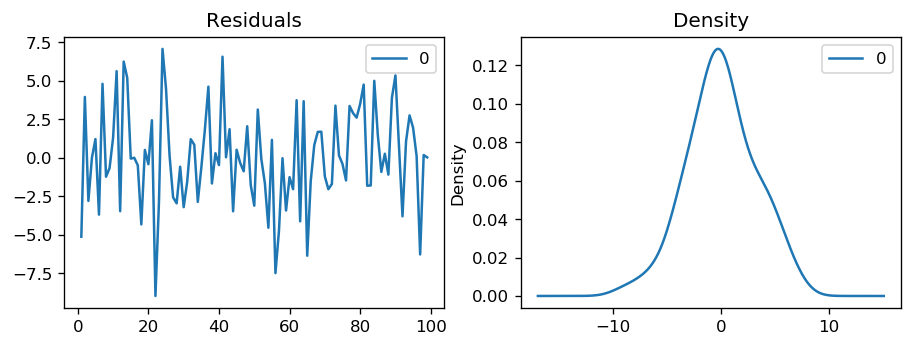

In [29]:
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(kind = 'kde', title = "Density", ax = ax[1])
plt.show()

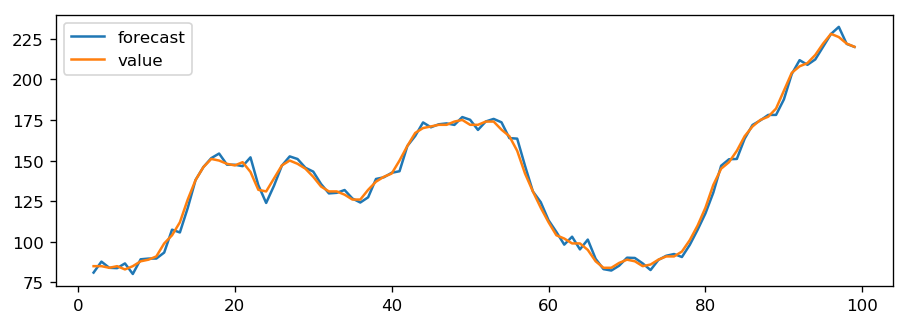

In [30]:
model_fit.plot_predict(dynamic = False)
plt.show()

In [31]:
from statsmodels.tsa.stattools import acf
train  = df.value[:85]
test = df.value[85:]

# With order (1,1,1), the model gives correct forecast, but still by adding some more constant (3,2,1) , we can improve the prediction. Try both...

In [32]:
model = ARIMA(train, order = (3,2,1))

# model = ARIMA(train, order = (1,1,1))

fitted = model.fit(disp = 1)

In [33]:
fc, se, conf = fitted.forecast(15, alpha = 0.05)
print(fc)

[165.1314426  173.0721238  179.32540628 185.02618422 190.73774376
 196.27626819 201.44830161 206.31591769 211.0077752  215.57402061
 220.01465663 224.33960257 228.57559266 232.74719102 236.86958486]


In [34]:
fc_series = pd.Series(fc, index = test.index)

In [35]:
lower_series = pd.Series(conf[:,0], index = test.index)

In [36]:
upper_series = pd.Series(conf[:,1], index = test.index)

In [37]:
plt.figure(figsize = (12,5), dpi = 100)

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

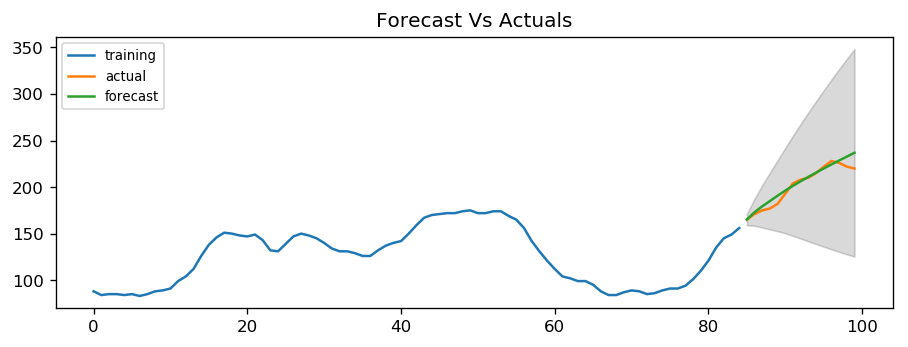

In [38]:
plt.plot(train, label = "training")
plt.plot(test, label = "actual")
plt.plot(fc_series, label = "forecast")
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .15)
plt.title('Forecast Vs Actuals')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

# Accuracy Metrics for the Forecast

In [39]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast- actual)/np.abs(actual))
    me = np.mean(forecast- actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast- actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    corr = np.corrcoef(forecast, actual)[0,1]
    mins = np.amin(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:,None]]), axis = 1)
    minmax = 1 - np.mean(mins/maxs)
    acf1 = acf(fc-test)[1]
    return({'mape': mape,
           'me': me,
           'mae': mae,
           'mpe': mpe,
           'rmse': rmse,
           'corr': corr,
           'acf1': acf1,
           'minmax': minmax})
forecast_accuracy(fc, test.values)

C:\Users\751026\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'mape': 0.022501320639815293,
 'me': 3.230787446595288,
 'mae': 4.548323646576828,
 'mpe': 0.01642102225925985,
 'rmse': 6.373241132743812,
 'corr': 0.9674576522618462,
 'acf1': 0.5105505497543064,
 'minmax': 0.021631554023586075}

In [40]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [41]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

In [42]:
df.head()

,value
0,88
1,84
2,85
3,85
4,84


In [43]:
model = pm.auto_arima(df.value, start_p = 1, start_q = 1, test = 'adf', max_p = 3, max_q = 3, m = 1, d = None, seasonal = False, 
                     start_P = 0, D = 0, trace = True, error_action = 'ignore', suppress_warnings = True, stepwise = True)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=525.587, BIC=535.926, Fit time=0.314 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=533.474, BIC=538.644, Fit time=0.007 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=532.437, BIC=540.192, Fit time=0.019 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=525.893, BIC=533.648, Fit time=0.025 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=531.477, BIC=534.062, Fit time=0.006 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=515.248, BIC=528.173, Fit time=0.046 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=513.459, BIC=523.799, Fit time=0.033 seconds
Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=515.284, BIC=528.209, Fit time=0.037 seconds
Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=512.556, BIC=528.066, Fit time=0.236 seconds
Near non-invertible roots for order (3, 2, 1)(0, 0, 0, 

In [44]:
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(3, 2, 1)   Log Likelihood                -250.278
Date:                Tue, 14 Jan 2020   AIC                            512.556
Time:                        11:19:49   BIC                            528.066
Sample:                             0   HQIC                           518.829
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.011      0.343      0.731      -0.018       0.025
ar.L1          1.1561      0.115     10.024      0.000       0.930       1.382
ar.L2         -0.6616      0.139     -4.766      0.0

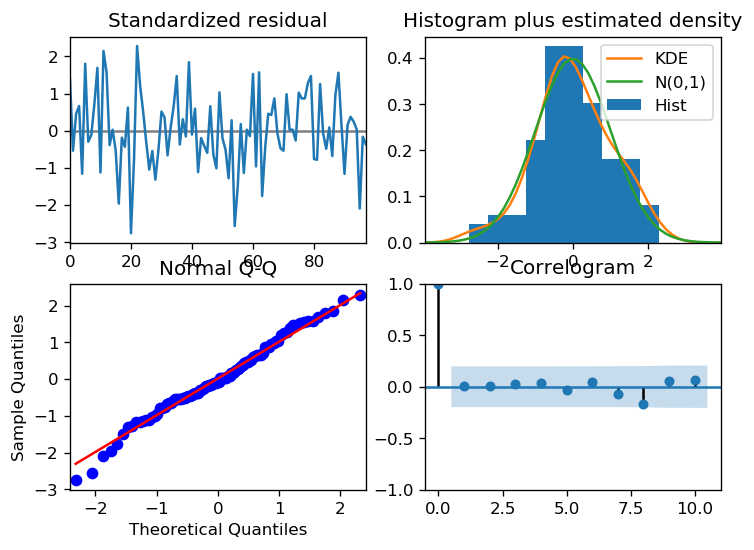

In [45]:
model.plot_diagnostics(figsize=(7,5))
plt.show()